<a href="https://colab.research.google.com/github/InfiKnight-TGP/Pokemon-Colour-Sorter/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!pip install scikit-learn pillow webcolors

# **Import Libraries**

In [106]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import glob
import matplotlib.pyplot as plt
import webcolors

# **Extract Dominant Colors**

This function processes an image and extracts its dominant colors using K-means clustering

In [107]:
def extract_dominant_colors(image_path, num_colors=3, visualize=False):
    if not image_path.lower().endswith('.png'):
        print(f"Skipping non-PNG file: {image_path}")
        return None, []

    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((100, 100))
        img_array = np.array(img)
        pixels = img_array.reshape(-1, 3)

        black_mask = ~np.all(pixels < 30, axis=1)
        filtered_pixels = pixels[black_mask]
        pixels_for_kmeans = filtered_pixels if len(filtered_pixels) > 100 else pixels

        kmeans = KMeans(n_clusters=num_colors, n_init=10)
        kmeans.fit(pixels_for_kmeans)

        labels = kmeans.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        sorted_indices = np.argsort(-counts)
        colors = kmeans.cluster_centers_[sorted_indices].astype(int)
        color_percentages = counts[sorted_indices] / len(labels) * 100
        hex_colors = ['#%02x%02x%02x' % tuple(color) for color in colors]

        if visualize:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            dominant_colors_display = np.zeros((100, 100, 3), dtype=np.uint8)
            y_start = 0
            for i, color in enumerate(colors):
                height = max(int(color_percentages[i]), 1)
                y_end = min(y_start + height, 100)
                dominant_colors_display[y_start:y_end, :] = color
                y_start = y_end
            plt.imshow(dominant_colors_display)
            plt.title("Dominant Colors")
            plt.axis('off')

            plt.show()

        return hex_colors[0], [{
            'hex': hex_colors[i],
            'rgb': colors[i].tolist(),
            'percentage': color_percentages[i]
        } for i in range(len(colors))]
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, []

# **Color Name Matching**

These functions help convert RGB values to human-readable color names

In [108]:
def closest_colour(requested_colour):
    min_colours = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        min_colours[(r_c - requested_colour[0]) ** 2 + (g_c - requested_colour[1]) ** 2 + (b_c - requested_colour[2]) ** 2] = name
    return min_colours[min(min_colours.keys())]

In [109]:
def get_color_name(rgb_tuple):
    try:
        return webcolors.hex_to_name(webcolors.rgb_to_hex(rgb_tuple))
    except ValueError:
        return closest_colour(rgb_tuple)

# **Process Pokémon Images and Update CSV**

 Process Pokémon images to extract dominant colors and update CSV data.

In [110]:
def process_pokemon_images(csv_filename, image_folder, num_colors=3, show_samples=3):
    original_df = pd.read_csv(csv_filename)
    if 'Num' not in original_df.columns or 'Name' not in original_df.columns:
        print("Error: CSV must have 'Num' and 'Name' columns")
        return None

    clean_df = original_df[['Num', 'Name']].copy()
    clean_df['Colour'] = ''

    image_files = {os.path.basename(file): file for file in glob.glob(os.path.join(image_folder, '*.png'))}
    sample_count = 0

    for index, row in clean_df.iterrows():
        pokemon_num = str(row['Num'])
        pokemon_name = row['Name']
        possible_filename = f"{pokemon_num}.png"
        matching_file = image_files.get(possible_filename, None)

        if not matching_file:
            matching_file = next((file for file in image_files.values() if pokemon_num in os.path.basename(file)), None)

        if not matching_file:
            print(f"No PNG found for Pokémon #{pokemon_num} ({pokemon_name})")
            clean_df.at[index, 'Colour'] = 'PNG not found'
            continue

        visualize = sample_count < show_samples
        dominant_color, _ = extract_dominant_colors(matching_file, num_colors, visualize)

        if not dominant_color:
            clean_df.at[index, 'Colour'] = 'Color extraction failed'
            continue

        dominant_color_rgb = tuple(int(dominant_color[i:i+2], 16) for i in (1, 3, 5))
        clean_df.at[index, 'Colour'] = get_color_name(dominant_color_rgb)

        if visualize:
            print(f"{pokemon_name} (#{pokemon_num}): Dominant Color - {clean_df.at[index, 'Colour']}")
            print("-" * 50)
            sample_count += 1

    output_filename = os.path.splitext(csv_filename)[0] + '_Colours.csv'
    clean_df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")

    try:
        from google.colab import files
        files.download(output_filename)
    except:
        print("Not running in Colab. File saved locally.")

    return clean_df

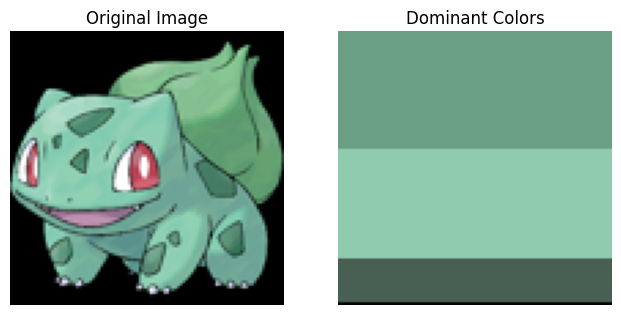

Bulbasaur (#1): Dominant Color - cadetblue
--------------------------------------------------


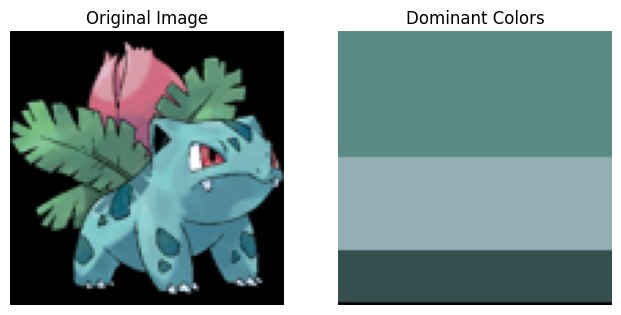

Ivysaur (#2): Dominant Color - slategrey
--------------------------------------------------


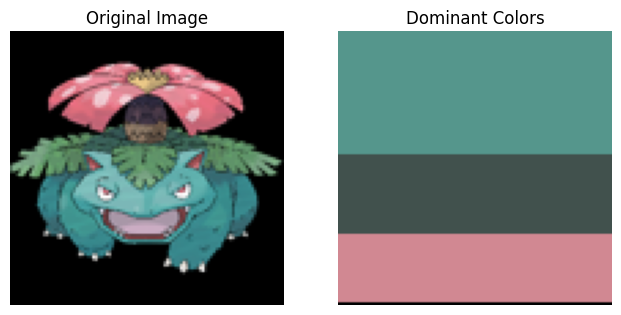

Venusaur (#3): Dominant Color - cadetblue
--------------------------------------------------
Results saved to /content/PokemonData_Colours.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [111]:
csv_file = "/content/PokemonData.csv"
image_folder = "/content/Pokemon"
result_df = process_pokemon_images(csv_filename=csv_file,image_folder=image_folder,num_colors=3,show_samples=1)
#Hex Values extracted are more Accurate However the Colour names getting converted may be inaccurate.Tried many fixes nothing works